<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/indicator/nse_pe_2_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss

# Suppress warnings (optional)
import warnings
warnings.filterwarnings('ignore')

# Set plot style
sns.set_style('whitegrid')

# Step 1: Data Import and Cleaning
# Assume the CSV file is named 'nifty_pe_data.csv' with columns 'Date' and 'PE_Ratio'

# Read the data
df = pd.read_csv("https://raw.githubusercontent.com/anirbanghoshsbi/.github.io/master/work/ml/data_fundamental.csv")
#df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)


# Handle missing values (if any)
#df['feat_PE'].fillna(method='ffill', inplace=True)  # Forward fill
#df['PE_Ratio'].fillna(method='bfill', inplace=True)  # Backward fill if needed

# Step 2: Stationarity Testing
# Define ADF test function
def adf_test(series, title=''):
    print(f'\nAugmented Dickey-Fuller Test: {title}')
    result = adfuller(series.dropna(), autolag='AIC')
    labels = ['ADF Statistic', 'p-value', '# Lags Used', '# Observations Used']
    out = pd.Series(result[0:4], index=labels)
    for key, value in result[4].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("=> The series is stationary.")
    else:
        print("=> The series is non-stationary.")

# Define KPSS test function
def kpss_test(series, title=''):
    print(f'\nKPSS Test: {title}')
    result = kpss(series.dropna(), regression='c', nlags='auto')
    labels = ['KPSS Statistic', 'p-value', '# Lags Used']
    out = pd.Series(result[0:3], index=labels)
    for key, value in result[3].items():
        out[f'Critical Value ({key})'] = value
    print(out.to_string())
    if result[1] <= 0.05:
        print("=> The series is non-stationary.")
    else:
        print("=> The series is stationary.")

# Apply the tests on the original series
adf_test(df['feat_PE'], title='P/E Ratio Original Series')
kpss_test(df['feat_PE'], title='P/E Ratio Original Series')

# Step 3: Differencing to Achieve Stationarity
df['PE_Ratio_Diff'] = df['feat_PE'].diff()

# Apply the tests on the differenced series
adf_test(df['PE_Ratio_Diff'].dropna(), title='First Differenced Series')
kpss_test(df['PE_Ratio_Diff'].dropna(), title='First Differenced Series')
df=df.tail(750)
# Step 4: Rolling Analysis with a 3-Year Window (Assuming Monthly Data)
window_size = 24  # 3 years * 12 months

# Calculate rolling mean and standard deviation
df['Rolling_Mean'] = df['feat_PE'].rolling(window=window_size).mean()
df['Rolling_STD'] = df['feat_PE'].rolling(window=window_size).std()

# Compute rolling Z-scores
df['Rolling_Z_Score'] = (df['feat_PE'] - df['Rolling_Mean']) / df['Rolling_STD']

# Step 5: Setting Overvaluation and Undervaluation Thresholds
overvaluation_threshold = 2
undervaluation_threshold = -2

# Generate signals
df['Signal'] = 0
df.loc[df['Rolling_Z_Score'] > overvaluation_threshold, 'Signal'] = -1  # Overvalued
df.loc[df['Rolling_Z_Score'] < undervaluation_threshold, 'Signal'] = 1   # Undervalued




Augmented Dickey-Fuller Test: P/E Ratio Original Series
ADF Statistic             -3.396514
p-value                    0.011078
# Lags Used               17.000000
# Observations Used     6409.000000
Critical Value (1%)       -3.431371
Critical Value (5%)       -2.861991
Critical Value (10%)      -2.567010
=> The series is stationary.

KPSS Test: P/E Ratio Original Series
KPSS Statistic            5.445314
p-value                   0.010000
# Lags Used              51.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
=> The series is non-stationary.

Augmented Dickey-Fuller Test: First Differenced Series
ADF Statistic          -1.747677e+01
p-value                 4.511893e-30
# Lags Used             1.600000e+01
# Observations Used     6.409000e+03
Critical Value (1%)    -3.431371e+00
Critical Value (5%)    -2.861991e+00
Critical Value (10%)   -2.567010e+00
=> The series is stationary.

K

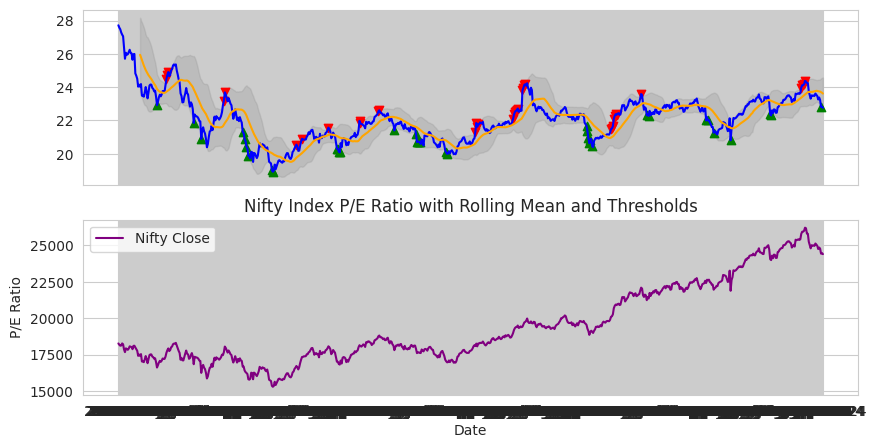

In [2]:

# Step 6: Visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5), sharex=True)
ax1.plot(df.index, df['feat_PE'], label='P/E Ratio', color='blue')
ax1.plot(df.index, df['Rolling_Mean'], label='Rolling Mean (36 days)', color='orange')
ax1.fill_between(df.index, df['Rolling_Mean'] + overvaluation_threshold * df['Rolling_STD'],
                 df['Rolling_Mean'] - overvaluation_threshold * df['Rolling_STD'],
                 color='gray', alpha=0.2, label='Threshold Band')

# Highlight signals
ax1.scatter(df.index[df['Signal'] == -1], df['feat_PE'][df['Signal'] == -1],
            marker='v', color='red', label='Overvalued')
ax1.scatter(df.index[df['Signal'] == 1], df['feat_PE'][df['Signal'] == 1],
            marker='^', color='green', label='Undervalued')

plt.title('Nifty Index P/E Ratio with Rolling Mean and Thresholds')
plt.xlabel('Date')
plt.ylabel('P/E Ratio')
ax2.plot(df.index, df['Close'], label='Nifty Close', color='purple')
plt.legend(loc='best')
plt.show()
